<b>Target :</b>

```1. Add Image Augmentation to reduce overfitting and increase network accuracy  ```

In [1]:
!pip install torchsummary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0,7.0), fill=(1,)),
                                      #  transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 99917354.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41385614.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33248678.62it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18057373.24it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

def model_summary():
  model = Net().to(device)
  summary(model, input_size=(1, 28, 28))

cuda


In [6]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [7]:
def plot_result():
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

In [8]:
class Net(nn.Module):

    def conv_block (self, in_channels, out_channels, kernel_size, padding = 1) :
      return nn.Sequential(
            nn.Conv2d (in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(0.02))

    def out_block(self, in_channels, kernel_size = 1):
      return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=10, kernel_size = kernel_size, padding = 0, bias = False))


    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = self.conv_block(1, 10, 3)
      self.conv2 = self.conv_block(10, 10, 3, 0)
      self.conv3 = self.conv_block(10, 11, 3)
      self.conv4 = self.conv_block(11, 11, 3, 0)
      self.conv5 = self.conv_block(11, 12, 3)
      self.conv6 = self.conv_block(12, 12, 3, 0)
      self.conv7 = self.out_block(12, 3)
      self.pool = nn.MaxPool2d(2, 2)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

model_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 26, 26]             900
              ReLU-6           [-1, 10, 26, 26]               0
       BatchNorm2d-7           [-1, 10, 26, 26]              20
           Dropout-8           [-1, 10, 26, 26]               0
         MaxPool2d-9           [-1, 10, 13, 13]               0
           Conv2d-10           [-1, 11, 13, 13]             990
             ReLU-11           [-1, 11, 13, 13]               0
      BatchNorm2d-12           [-1, 11, 13, 13]              22
          Dropout-13           [-1, 11, 13, 13]               0
           Conv2d-14           [-1, 11,

In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.11260067671537399 Batch_id=468 Accuracy=94.56: 100%|██████████| 469/469 [00:41<00:00, 11.27it/s]



Test set: Average loss: 0.0511, Accuracy: 9848/10000 (98.48%)

EPOCH: 1


Loss=0.04116788133978844 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:37<00:00, 12.53it/s]



Test set: Average loss: 0.0414, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


Loss=0.03137608990073204 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:37<00:00, 12.40it/s]



Test set: Average loss: 0.0322, Accuracy: 9899/10000 (98.99%)

EPOCH: 3


Loss=0.018266834318637848 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:37<00:00, 12.60it/s]



Test set: Average loss: 0.0322, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Loss=0.03053828328847885 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:36<00:00, 12.72it/s]



Test set: Average loss: 0.0301, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.020131641998887062 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:38<00:00, 12.05it/s]



Test set: Average loss: 0.0276, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.022233126685023308 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:37<00:00, 12.61it/s]



Test set: Average loss: 0.0253, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.046269625425338745 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:37<00:00, 12.43it/s]



Test set: Average loss: 0.0259, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.047500014305114746 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]



Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.03729286417365074 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:38<00:00, 12.28it/s]



Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.011212926357984543 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:38<00:00, 12.32it/s]



Test set: Average loss: 0.0243, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.006769025698304176 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]



Test set: Average loss: 0.0221, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.044937971979379654 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:39<00:00, 11.86it/s]



Test set: Average loss: 0.0225, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.011706552468240261 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:37<00:00, 12.48it/s]



Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.06454551964998245 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:37<00:00, 12.39it/s]



Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)



Text(0.5, 1.0, 'Test Accuracy')

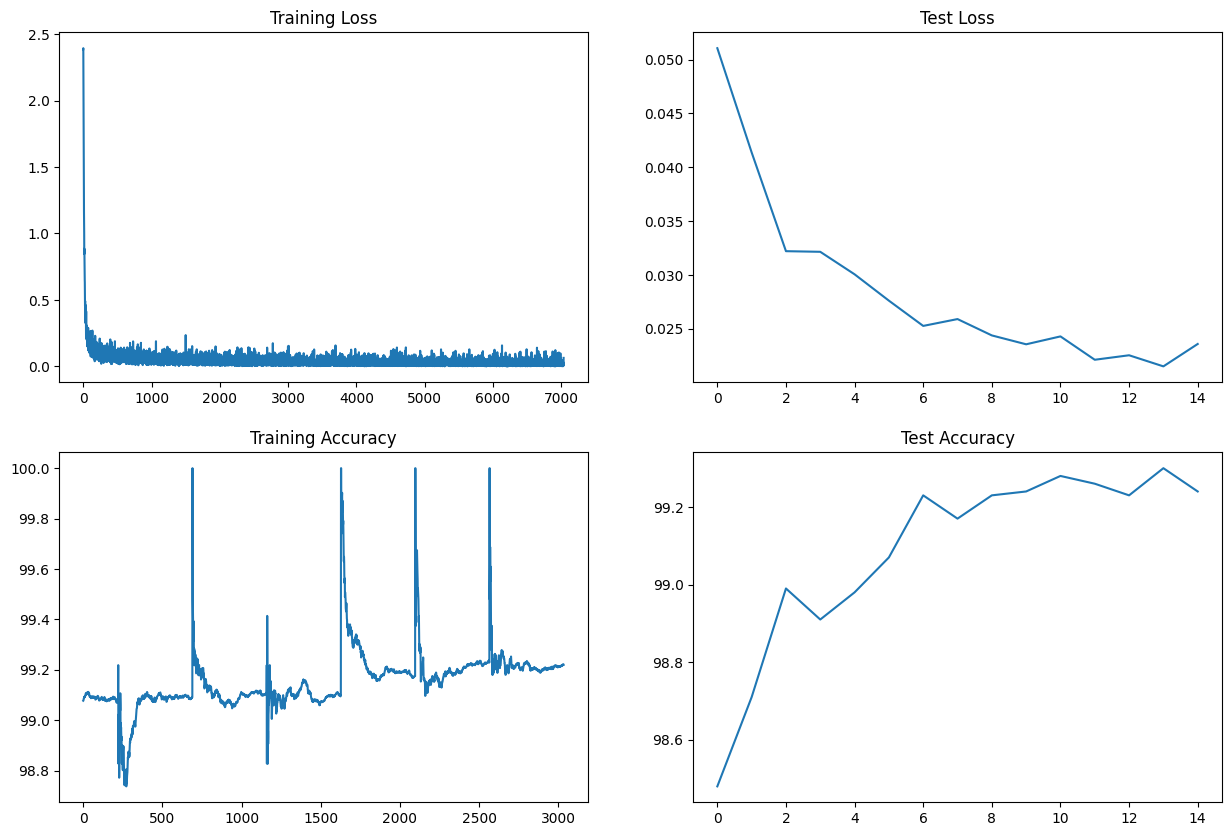

In [10]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Results:

<b>Parameters:</b> 6,765

<b>Best Train Accuracy:</b> 99.22

<b>Best Test Accuracy:</b> 99.30

<b>Analysis:</b>
Based on the result we can observe that network is underfitting but that is because we are trying to force our network to learn harder on train data. Using image augmentation has improved our network capacity and was able to achieve almost the required target with 6,765 parameters